# COVID-19, An Analysis

### Joshua Wentling

***

## Introduction

On December 31, 2019, the CDC became aware of a cluster of pneumonia cases in Wuhan, China. These, as we later learned, were the first known cases of COVID-19. By January 30, 2020, WHO declared the COVID-19 outbreak a global health emergency. By mid March, much of the U.S. was in lockdown and many state-wide stay-at-home orders were issued.
As of December 2020, the pandemic is growing still with an estimated over 74 million cases worldwide. It has been a rollercoaster of a year, but hopefully with the recent vaccine approvals we will see this pandemic come to an end soon. Until then, people around the world are encouraged to stay at home as much as possible and maintain social distancing measures.
<br><br>
It has been almost a year since the pandemic started. Thanks to the hard work of data scientists, we have data for confirmed cases, deaths, and recoveries for every country around the world for each day since this pandemic started. With that data, we can do a lot of analysis and learn more about how the virus has affected different countries (and different states/provinces within those countries) and possibly even build a model using machine learning based on this data.
This tutorial will walk you through the entire data science pipeline using data related to COVID-19, and hopefully by the end of it you will have learned a thing or two.

## Table of Contents

This page is broken up into two parts. The first is a more basic analysis on COVID-19 at the global scale and incorporates all the countries around the world that the dataset I used includes. The second part does this same analysis on COVID-19 within the United States on a state level, then it goes into a deeper analysis on the US including the development of a machine learning model. Much of the code from the first part is repeated in the second part, so I will be including less of an explanation for the repeated code to reduce redundancy.

- Data Import <br>
- **Global**
    - Initial Data Processing
    - Graph and Analysis
    - Choropleth
- **United States**
    - Graph and Analysis
    - Choropleth
    - Machine Leaning
- Conclusion

<hr>

## Imports

We will start with our imports. These are all the necessary libraries that we will be using for this tutorial.

In [1]:
# !pip install folium
# !pip install geopandas
import pandas as pd
import folium
from folium import plugins
from folium.plugins import TimeSliderChoropleth
import branca.colormap as cm
import numpy as np
import math
from matplotlib.ticker import FormatStrFormatter
import matplotlib.ticker as mtick
import scipy
from scipy import stats
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# Global

## Initial Data Processing

Next, we will import our data from a csv and take a look.

In [2]:
# https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset
df = pd.read_csv('Data/Covid/covid_19_data.csv')

pd.set_option('display.max_rows', None)
df.head()

SNo ObservationDate Province/State  Country/Region      Last Update  \
0    1      01/22/2020          Anhui  Mainland China  1/22/2020 17:00   
1    2      01/22/2020        Beijing  Mainland China  1/22/2020 17:00   
2    3      01/22/2020      Chongqing  Mainland China  1/22/2020 17:00   
3    4      01/22/2020         Fujian  Mainland China  1/22/2020 17:00   
4    5      01/22/2020          Gansu  Mainland China  1/22/2020 17:00   

   Confirmed  Deaths  Recovered  
0        1.0     0.0        0.0  
1       14.0     0.0        0.0  
2        6.0     0.0        0.0  
3        1.0     0.0        0.0  
4        0.0     0.0        0.0

In [3]:
dftemp = df.copy()
dftemp = dftemp.groupby(['Country/Region', 'ObservationDate'], as_index=False).sum()
dftemp = dftemp.sort_values('Confirmed', ascending=False).drop_duplicates(['Country/Region'])
dftemp.sort_values(by=['Country/Region'], ascending=False).astype(str).head()

Country/Region ObservationDate     SNo Confirmed  \
53007  occupied Palestinian territory      03/10/2020    4593      25.0   
53006                        Zimbabwe      12/06/2020  171890   10718.0   
52744                          Zambia      12/06/2020  171889   17916.0   
52480                           Yemen      12/06/2020  171888    2337.0   
52087                  Western Sahara      07/07/2020   58571      10.0   

      Deaths Recovered  
53007    0.0       0.0  
53006  291.0    8880.0  
52744  364.0   17173.0  
52480  639.0    1549.0  
52087    1.0       8.0

## Graph and Analysis

Let's start by making a line graph of cases over time.

We'll make a copy of the original dataframe so that we can make edits for our line graph. The original dataset breaks the cases down by province/state. For this graph, we will just be looking at the data per country. To account for this, we will sum the data by country and oberservation date.

In [4]:
dfl = df.copy()
# Get the sum of all confirmed cases in every country for each day
dfl = dfl.groupby(['ObservationDate'], as_index=False).sum()
# Remove all unnecessary data
dfl = dfl[['ObservationDate','Confirmed']]
dfl.head()

ObservationDate  Confirmed
0      01/22/2020      555.0
1      01/23/2020      653.0
2      01/24/2020      941.0
3      01/25/2020     1438.0
4      01/26/2020     2118.0

In [5]:
# Convert the observation date strings to a pd datetime
dfl['ObservationDate'] = dfl['ObservationDate'].apply(pd.to_datetime)
# Adjust the scale of case numbers to millions
dfl['Confirmed'] = dfl['Confirmed']/1000000
# Makes each column a different date for plotting
dfl = dfl.set_index('ObservationDate')

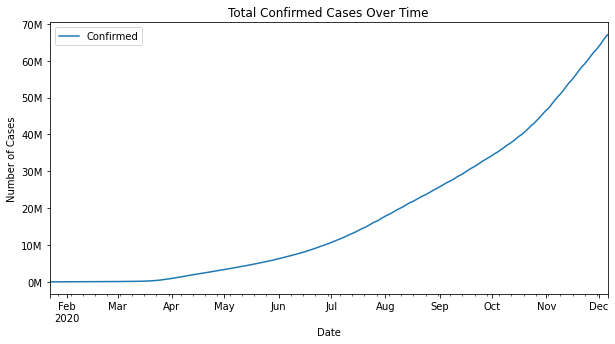

In [6]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)

ax = dfl.plot()
ax.set_xlabel('Date')
ax.set_ylabel('Number of Cases')
ax.set_title('Total Confirmed Cases Over Time')

formatter = FormatStrFormatter('%0.0fM')
ax.yaxis.set_major_formatter(formatter) 

Let's choose a few specific countries to see how their confirmed cases compare

In [7]:
dftemp = df.copy()
dftemp = dftemp.groupby(['Country/Region', 'ObservationDate'], as_index=False).sum()
dftemp = dftemp.sort_values('Confirmed', ascending=False).drop_duplicates(['Country/Region'])
dftemp = dftemp.sort_values(by=['Confirmed'], ascending=False).astype(str).head(7)
dftemp

Country/Region ObservationDate       SNo   Confirmed    Deaths  \
49731             US      12/06/2020   9987689  14757000.0  282299.0   
21902          India      12/06/2020   6370326   9677203.0  140573.0   
6676          Brazil      12/06/2020   4648893   6603540.0  176941.0   
39600         Russia      12/06/2020  14293198   2439163.0   42675.0   
16846         France      12/06/2020   1893885   2345648.0   55247.0   
23645          Italy      12/06/2020   3616285   1728878.0   60078.0   
49411             UK      12/06/2020   2582103   1727751.0   61342.0   

       Recovered  
49731  5624444.0  
21902  9139901.0  
6676   5866657.0  
39600  1920744.0  
16846   175220.0  
23645   913494.0  
49411     3736.0

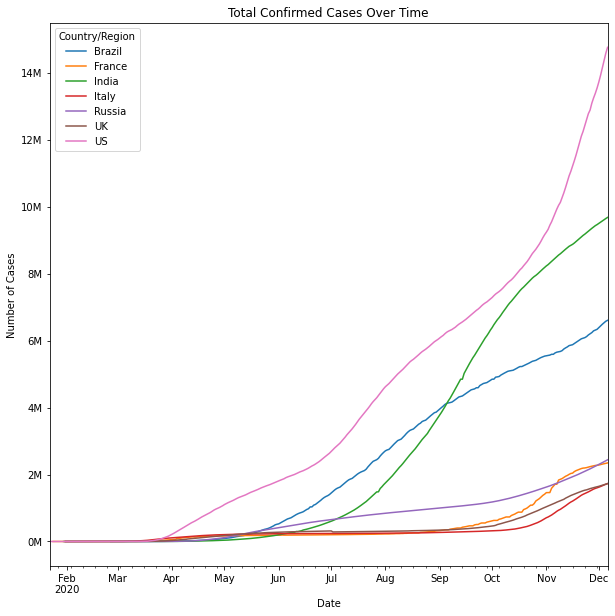

In [8]:
dfl = df.copy()

# Select the countries we want to see
country_list = dftemp['Country/Region'].tolist()
dfl = dfl.loc[dfl['Country/Region'].isin(country_list)]


# Repeat steps from last line graph
dfl = dfl.groupby(['Country/Region', 'ObservationDate'], as_index=False).sum()

# Remove all unnecessary data
df_confirmed = dfl.copy()
df_confirmed = df_confirmed[['Country/Region','ObservationDate','Confirmed']]
# Convert the observation date strings to a pd datetime
df_confirmed['ObservationDate'] = df_confirmed['ObservationDate'].apply(pd.to_datetime)
# Adjust the scale of case numbers to millions
df_confirmed['Confirmed'] = df_confirmed['Confirmed']/1000000
# Adjust dataframe for plotting
df_confirmed = df_confirmed.pivot(index='ObservationDate', columns='Country/Region', values='Confirmed')

plt.rcParams["figure.figsize"] = (10,10)

ax = df_confirmed.plot()
ax.set_xlabel('Date')
ax.set_ylabel('Number of Cases')
ax.set_title('Total Confirmed Cases Over Time')

formatter = FormatStrFormatter('%0.0fM')
ax.yaxis.set_major_formatter(formatter)

Let's take a look at the same graph but for deaths instead of total cases.

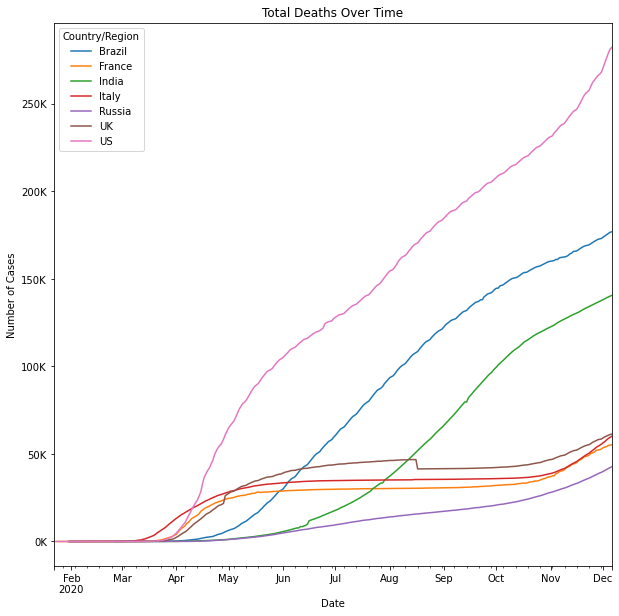

In [9]:
df_deaths = dfl.copy()
df_deaths = df_deaths[['Country/Region','ObservationDate','Deaths']]
# Convert the observation date strings to a pd datetime
df_deaths['ObservationDate'] = df_deaths['ObservationDate'].apply(pd.to_datetime)
# Adjust the scale of case numbers to millions
df_deaths['Deaths'] = df_deaths['Deaths']/1000
# Adjust dataframe for plotting
df_deaths = df_deaths.pivot(index='ObservationDate', columns='Country/Region', values='Deaths')

plt.rcParams["figure.figsize"] = (10,10)

ax = df_deaths.plot()
ax.set_xlabel('Date')
ax.set_ylabel('Number of Cases')
ax.set_title('Total Deaths Over Time')

formatter = FormatStrFormatter('%0.0fK')
ax.yaxis.set_major_formatter(formatter)

While this graph is interesting, it doesn't tell us a whole lot about how each of these countries have handled the outbreak overall, since a country with a smaller population is far less likely to make it onto this list, even if a large percentage of the population was infected. Let's redo this analysis using cases as a percentage of the country's total population.

In [10]:
# Data from: https://population.un.org/wpp/Download/Standard/CSV/
df_pop = pd.read_csv('Data/WPP2019_TotalPopulationBySex.csv')
# We only want data for 2020
df_pop = df_pop[df_pop['Time'] == 2020]
# We want just one row per country
df_pop = df_pop.groupby(['Location', 'Time'], as_index=False).mean()
# Get rid of unnecessary columns
df_pop = df_pop[['Location','PopTotal']]
# Population is in thousands, let's fix that
df_pop['PopTotal'] = df_pop['PopTotal']*1000

# Rename 'Location' to 'Country/Region' so the merge works properly
df_pop = df_pop.rename(columns={'Location': 'Country/Region'})

Now we have a list of countries and population totals for the year 2020! Next we will want to merge this with our existing dataframe. We will use a left merge on the existing dataframe (since that's the most important one) and then take a look to see if we're missing any population data.

First we must see if there is any missing data. Using the code below, we will display only the countries whose population total is NaN, meaning that it did not merge properly with our population data.

In [11]:
# We will not be keeping this dataframe, hence why I used 'dftemp'
dftemp = df.copy()
# Left merge because we only care about countries that we have covid data for
dftemp = dftemp.merge(df_pop, on='Country/Region', how='left')
dftemp = dftemp[np.isnan(dftemp['PopTotal'])]
dftemp.groupby(['Country/Region'], as_index=False).mean().head()

Country/Region           SNo     Confirmed       Deaths     Recovered  \
0       Azerbaijan   2664.000000      1.000000     0.000000      0.000000   
1  ('St. Martin',)   4675.000000      2.000000     0.000000      0.000000   
2     Bahamas, The   7253.666667      3.333333     0.000000      0.000000   
3          Bolivia  76018.431734  69601.712177  3722.612546  43647.557196   
4           Brunei  75495.948718    137.062271     2.278388    124.380952   

   PopTotal  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN

Using this list, let's fill in as much of the missing data as we can. Unfortunately, we will not have data for every single country. However, smaller countries with little or no data likely won't have an effect on the analysis we are doing.

In [12]:
df_pop = df_pop.replace({'Country/Region':'Russian Federation'},'Russia')
df_pop = df_pop.replace({'Country/Region':'United States of America'},'US')
df_pop = df_pop.replace({'Country/Region':'Iran (Islamic Republic of)'},'Iran')
df_pop = df_pop.replace({'Country/Region':'Bahamas'},'Bahamas, The')
df_pop = df_pop.replace({'Country/Region':'Azerbaijan'},'Azerbaijan')
df_pop = df_pop.replace({'Country/Region':'United Kingdom'},'UK')
df_pop = df_pop.replace({'Country/Region':'Bolivia (Plurinational State of)'},'Bolivia')
df_pop = df_pop.replace({'Country/Region':'Brunei Darussalam'},'Brunei')
df_pop = df_pop.replace({'Country/Region':'Democratic Republic of the Congo'},'Congo (Kinshasa)')
df_pop = df_pop.replace({'Country/Region':'Congo'},'Congo (Brazzaville)')
df_pop = df_pop.replace({'Country/Region':'Curaçao'},'Curacao')
df_pop = df_pop.replace({'Country/Region':'Czechia'},'Czech Republic')
df_pop = df_pop.replace({'Country/Region':'Timor-Leste'},'East Timor')
df_pop = df_pop.replace({'Country/Region':'China, Hong Kong SAR'},'Hong Kong')
df_pop = df_pop.replace({'Country/Region':'China'},'Mainland China')
df_pop = df_pop.replace({'Country/Region':'Republic of Korea'},'South Korea')
df_pop = df_pop.replace({'Country/Region':'China, Taiwan Province of China'},'Taiwan')
df_pop = df_pop.replace({'Country/Region':'United Republic of Tanzania'},'Tanzania')
df_pop = df_pop.replace({'Country/Region':'Venezuela (Bolivarian Republic of)'},'Venezuela')

Then we can run our merge code again.

In [13]:
df_merge = df.copy()
df_merge = df_merge.merge(df_pop, on='Country/Region', how='left')

Finally, let's add a column that is confirmed cases divided by the population total to get us a confirmed percentage for each country.

In [14]:
df_merge['ConfirmedPercentage'] = df_merge['Confirmed']/df_merge['PopTotal']*100
df_merge.head()

SNo ObservationDate Province/State  Country/Region      Last Update  \
0    1      01/22/2020          Anhui  Mainland China  1/22/2020 17:00   
1    2      01/22/2020        Beijing  Mainland China  1/22/2020 17:00   
2    3      01/22/2020      Chongqing  Mainland China  1/22/2020 17:00   
3    4      01/22/2020         Fujian  Mainland China  1/22/2020 17:00   
4    5      01/22/2020          Gansu  Mainland China  1/22/2020 17:00   

   Confirmed  Deaths  Recovered      PopTotal  ConfirmedPercentage  
0        1.0     0.0        0.0  1.439324e+09         6.947707e-08  
1       14.0     0.0        0.0  1.439324e+09         9.726790e-07  
2        6.0     0.0        0.0  1.439324e+09         4.168624e-07  
3        1.0     0.0        0.0  1.439324e+09         6.947707e-08  
4        0.0     0.0        0.0  1.439324e+09         0.000000e+00

***

## Confirmed Cases as Percentage of Population

Now let's do some analysis using our new ConfirmedPercentage category.

We'll start with another line graph. Let's see if our top 5 countries are the same using ConfirmedPercentage instead of Confirmed.

In [15]:
dftemp = df_merge.copy()
dftemp = dftemp.groupby(['Country/Region', 'ObservationDate'], as_index=False).sum()
dftemp = dftemp.sort_values('ConfirmedPercentage', ascending=False).drop_duplicates(['Country/Region'])
dftemp = dftemp.sort_values(by=['ConfirmedPercentage'], ascending=False).astype(str).head(7)
dftemp

Country/Region ObservationDate      SNo Confirmed   Deaths Recovered  \
1127          Andorra      12/06/2020   171724    7050.0     78.0    6238.0   
33049      Montenegro      12/06/2020   171826   38246.0    533.0   26999.0   
28550      Luxembourg      12/06/2020   171812   37017.0    345.0   28029.0   
40951      San Marino      12/05/2020   171090    1789.0     48.0    1412.0   
3660          Bahrain      12/06/2020   171732   87930.0    341.0   86030.0   
12408  Czech Republic      12/06/2020   171759  546833.0   8902.0  478094.0   
4789          Belgium      12/06/2020  2066058  591756.0  17320.0       0.0   

                 PopTotal ConfirmedPercentage  
1127              77265.0     9.1244418559503  
33049            628062.0   6.089526193273912  
28550   625975.9999999999   5.913485501041574  
40951   33937.99999999999   5.271377217278568  
3660   1701582.9999999998  5.1675410485412705  
12408  10708982.000000002   5.106302354416133  
4789   139075392.00000003  5.1059155022910145

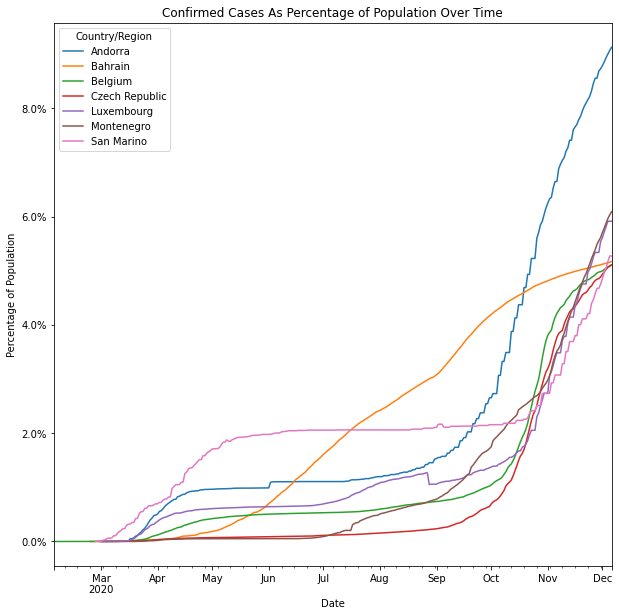

In [16]:
import matplotlib.ticker as mtick

dfl = df_merge.copy()

# Select the countries we want to see
country_list = dftemp['Country/Region'].tolist()
dfl = dfl.loc[dfl['Country/Region'].isin(country_list)]

# Repeat steps from last line graph
dfl = dfl.groupby(['Country/Region', 'ObservationDate'], as_index=False).sum()

# Remove all unnecessary data
df_confirmed = dfl.copy()
df_confirmed = df_confirmed[['Country/Region','ObservationDate','ConfirmedPercentage']]
# Convert the observation date strings to a pd datetime
df_confirmed['ObservationDate'] = df_confirmed['ObservationDate'].apply(pd.to_datetime)
# Adjust the scale of case numbers to millions
# Adjust dataframe for plotting
df_confirmed = df_confirmed.pivot(index='ObservationDate', columns='Country/Region', values='ConfirmedPercentage')

plt.rcParams["figure.figsize"] = (10,10)

ax = df_confirmed.plot()
ax.set_xlabel('Date')
ax.set_ylabel('Percentage of Population')
ax.set_title('Confirmed Cases As Percentage of Population Over Time')

formatter = mtick.PercentFormatter()
ax.yaxis.set_major_formatter(formatter)

This change to percentage of population gives us a bit more perspective. While the US is still in the top 10, it shows that their are a number of other countries with worse case rates relative to their total population. Andorra has a signficantly higher percentage than any other country at around 9%.

***

## Choropleth

Next, we will be making a time-based choropleth to illustrate the spread of the virus over time. There are a few different use cases and ways we can display our data using a time slider choropleth. To start, we will use it to show the overall spread of the virus over time from its beginning last January 2020 until early December of 2020. 

I used the following website as a reference to better understand TimeSliderChoropleth. Some of its parameters such as styledict, have very little documentation. From: https://www.jumpingrivers.com/blog/interactive-maps-python-covid-19-spread/

We will start by simply making a copy of the dataframe so we can make modification to it specific to the time slider choropleth.

In [17]:
# dfc: Data frame choropleth
dfc = df.copy()

Some countries have different labels than our geography database (which we will get to below). We must fix these labels so that they match.

In [18]:
dfc = dfc.replace({'Country/Region':'US'},'United States of America')
dfc = dfc.replace({'Country/Region':'Mainland China'},'China')
dfc = dfc.replace({'Country/Region':'UK'},'United Kingdom')
dfc = dfc.replace({'Country/Region':'Republic of the Congo'},'Congo (Brazzaville)')

Some countries are broken down by province/state. This means that the data is dispersed throughout these regions. Our geographic data only accounts for countries, so we will have to sum the data for the country as a whole.

In [19]:
dfc = dfc.groupby(['Country/Region', 'ObservationDate'], as_index=False).sum()

In [20]:
# Convert time to proper format for TimeSliderChoropleth
dfc['ObservationDate'] = pd.to_datetime(dfc['ObservationDate']).astype(int) / 10**9

# Take log of data since some countries have significantly high populations than others
dfc['Confirmed Adjusted'] = dfc['Confirmed'].apply(lambda x: math.log10(1+x)) # Add 1 to account for zeros

Next we need to calculate the color data for the TimeSliderChoropleth. This color map will evenly distribute a range of color hex's across a dataframe column based on their values. In this case, the color map is being applied to the number of confirmed cases. The specific color map used doesn't affect the data, just the colors used in the map.

In [21]:
max_color = max(dfc['Confirmed Adjusted'])
min_color = min(dfc['Confirmed Adjusted'])
cmap = cm.linear.YlOrRd_09.scale(min_color, max_color)
dfc['Color'] = dfc['Confirmed Adjusted'].apply(cmap)

First we must get the geography data for all countries. This is done using the geopandas dataset. Found here: https://nbviewer.jupyter.org/github/python-visualization/folium/blob/master/examples/TimeSliderChoropleth.ipynb

In [22]:
import geopandas as gpd
assert "naturalearth_lowres" in gpd.datasets.available
datapath = gpd.datasets.get_path("naturalearth_lowres")
gdf = gpd.read_file(datapath)

Next, we must create a style dictionary to store the color and opacity values for each date for each country. This is stored as a dictionary of dictionaries. Each entry in the dictionary correlates to a country and then the inner dictionary contains color values for each date.
<br><br>
A styledict is defined as: A dictionary where the keys are the geojson feature ids and the values are dicts of {time: style_options_dict}

In [23]:
styledict = {}

for index, row in gdf.iterrows():
    cdata = dfc[dfc['Country/Region'] == row['name']]
    temp_dict = {}
    
    for i, r in cdata.iterrows():
        temp_dict[str(r['ObservationDate'])] = {'color': r['Color'], 'opacity': 0.8}

    styledict[str(index)] = temp_dict

Finally, we need to create the folium map. Note that I was unable to map the data properly for a couple countries. Those countries will stay white even after adjusting the slider.

In [24]:
map_osm = folium.Map(min_zoom=2, max_bounds=True)

g = TimeSliderChoropleth(
    data=gdf.to_json(),
    styledict=styledict,
).add_to(map_osm)

_ = cmap.add_to(map_osm)

map_osm

***

# United States

As a US citizen who is much more familiar with the scope of political, legal, and cultural differences in different areas throughout the country, I would love to take a look at how COVID-19 has affected different states within the US. This analysis could easily be done using state or provincial data in another country. For this tutorial, I will use the US. I also believe the US is a great country to do this on because there are vast changes in population density, climate, and culture from state to state. I would love to do some analysis to see if we can find any statistically significant correlation between any of these factors and the rates of cases for COVID-19. Let's get started!

## Graph and Analysis

First we will need to create a dataframe with just the data for each US state.

In [25]:
df_us = df.copy()
df_us = df_us[df_us['Country/Region']=='US']

Next, we will repeat the steps above to create a line graph for the top worst states in terms of cases. I won't include explantations since we have already done all this above.

In [26]:
dftemp = df_us.copy()
dftemp = dftemp.groupby(['Province/State', 'ObservationDate'], as_index=False).sum()
dftemp = dftemp.sort_values('Confirmed', ascending=False).drop_duplicates(['Province/State'])
dftemp = dftemp.sort_values(by=['Confirmed'], ascending=False).astype(str).head(7)

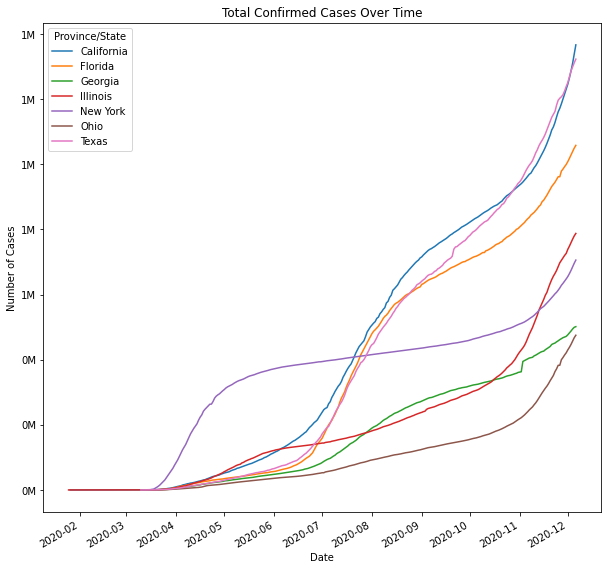

In [27]:
dfl = df_us.copy()

# Repeat steps from last line graph
dfl = dfl.groupby(['Province/State', 'ObservationDate'], as_index=False).sum()

# Save current dataframe for later
df_tot = dfl.copy()

# Select the countries we want to see
state_list = dftemp['Province/State'].tolist()
dfl = dfl.loc[dfl['Province/State'].isin(state_list)]

# Remove all unnecessary data
df_confirmed = dfl.copy()

df_confirmed = df_confirmed[['Province/State','ObservationDate','Confirmed']]
# Convert the observation date strings to a pd datetime
df_confirmed['ObservationDate'] = df_confirmed['ObservationDate'].apply(pd.to_datetime)
# Adjust the scale of case numbers to millions
df_confirmed['Confirmed'] = df_confirmed['Confirmed']/1000000
# Adjust dataframe for plotting
df_confirmed = df_confirmed.pivot(index='ObservationDate', columns='Province/State', values='Confirmed')

plt.rcParams["figure.figsize"] = (10,10)

ax = df_confirmed.plot()
ax.set_xlabel('Date')
ax.set_ylabel('Number of Cases')
ax.set_title('Total Confirmed Cases Over Time')

formatter = FormatStrFormatter('%0.0fM')
ax.yaxis.set_major_formatter(formatter)

Unsurprisingly, some of the US's most populous states have the most cases. While this is interesting to see graphically, I would be more interested in seeing how the different states compare relative to each other. I believe the best way to do this is to look at the proportion of people in each state who tested positive for COVID-19. To do this, we can import and merge total population data for each state and calculate the percentage of people in each state who have been infected.

In [28]:
# https://population.un.org/wpp/Download/Standard/CSV/
df_pop = pd.read_csv('Data/State Populations.csv')

# Rename 'Location' to 'Country/Region' so the merge works properly
df_pop = df_pop.rename(columns={'State': 'Province/State'})
df_pop = df_pop.rename(columns={'2018 Population': 'PopTotal'})

df_pop.head(10)

Province/State  PopTotal
0      California  39776830
1           Texas  28704330
2         Florida  21312211
3        New York  19862512
4    Pennsylvania  12823989
5        Illinois  12768320
6            Ohio  11694664
7         Georgia  10545138
8  North Carolina  10390149
9        Michigan   9991177

Now that we have the data organized nicely, let's merge this with our existing data and calculated the confirmed percentage.

In [29]:
df_merge = df_us.copy()
df_merge = df_merge.merge(df_pop, on='Province/State', how='inner')

df_merge['ConfirmedPercentage'] = df_merge['Confirmed']/df_merge['PopTotal']*100
df_merge.tail(10)

SNo ObservationDate Province/State Country/Region  \
13887  165057      11/27/2020        Alabama             US   
13888  165817      11/28/2020        Alabama             US   
13889  166577      11/29/2020        Alabama             US   
13890  167337      11/30/2020        Alabama             US   
13891  168097      12/01/2020        Alabama             US   
13892  168857      12/02/2020        Alabama             US   
13893  169617      12/03/2020        Alabama             US   
13894  170377      12/04/2020        Alabama             US   
13895  171137      12/05/2020        Alabama             US   
13896  171897      12/06/2020        Alabama             US   

               Last Update  Confirmed  Deaths  Recovered  PopTotal  \
13887  2020-11-28 05:25:50   242874.0  3572.0        0.0   4888949   
13888  2020-11-29 05:25:55   244993.0  3572.0        0.0   4888949   
13889  2020-11-30 05:26:13   247229.0  3577.0        0.0   4888949   
13890  2020-12-01 05:26:18   249524.0  3578.0        0.0   4888949   
13891  2020-12-02 05:27:41   252900.0  3638.0        0.0   4888949   
13892  2020-12-03 05:28:22   256828.0  3711.0        0.0   4888949   
13893  2020-12-04 05:27:27   260359.0  3776.0        0.0   4888949   
13894  2020-12-05 05:27:36   264199.0  3831.0        0.0   4888949   
13895  2020-12-06 05:26:18   267589.0  3877.0        0.0   4888949   
13896  2020-12-07 05:26:14   269877.0  3889.0        0.0   4888949   

       ConfirmedPercentage  
13887             4.967816  
13888             5.011159  
13889             5.056895  
13890             5.103837  
13891             5.172891  
13892             5.253235  
13893             5.325460  
13894             5.404004  
13895             5.473344  
13896             5.520143

Perfect. Since we only need the total number of confirmed cases for this analysis, we will drop all rows aside from the most recent one (since the number of confirmed cases in the table is cumulative).

In [30]:
dftemp = df_merge.copy()
# dftemp = dftemp.groupby(['Province/State', 'ObservationDate'], as_index=False).mean()
dftemp = dftemp.sort_values('ConfirmedPercentage', ascending=False).drop_duplicates(['Province/State'])
dftemp = dftemp.sort_values(by=['ConfirmedPercentage'], ascending=False).astype(str).head(7)

Now, we can run the code to create a table using our new confirmed percentage column to see which states have the highest percentage of covid cases.

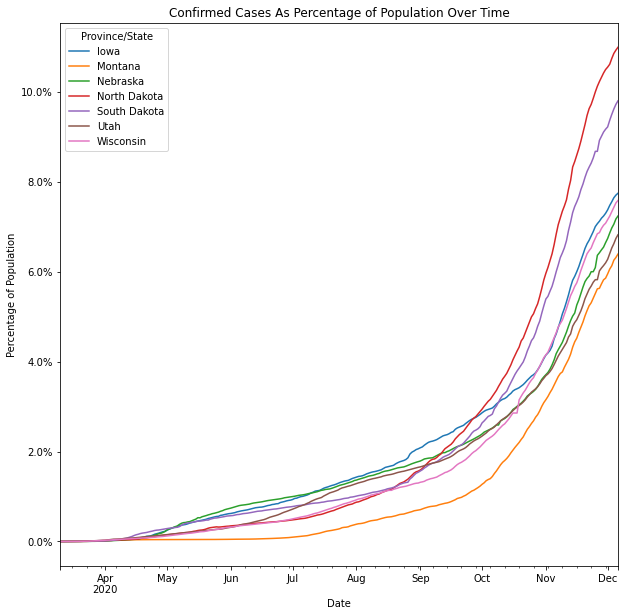

In [31]:
# dfl: dataframe line (graph)
dfl = df_merge.copy()

# Select the countries we want to see
country_list = dftemp['Province/State'].tolist()
# dfl = dfl.loc[dfl['Province/State'].isin(country_list)]


# Repeat steps from last line graph
dfl = dfl.groupby(['Province/State', 'ObservationDate'], as_index=False).sum()

# Remove all unnecessary data
df_confirmed = dfl.copy()
df_confirmed = df_confirmed[['Province/State','ObservationDate','ConfirmedPercentage']]

# Convert the observation date strings to a pd datetime
df_confirmed['ObservationDate'] = df_confirmed['ObservationDate'].apply(pd.to_datetime)
# Adjust dataframe for plotting
df_plot = df_confirmed.copy()
df_plot = df_plot.loc[dfl['Province/State'].isin(country_list)]
df_plot = df_plot.pivot(index='ObservationDate', columns='Province/State', values='ConfirmedPercentage')

plt.rcParams["figure.figsize"] = (10,10)

ax = df_plot.plot()
ax.set_xlabel('Date')
ax.set_ylabel('Percentage of Population')
ax.set_title('Confirmed Cases As Percentage of Population Over Time')

formatter = mtick.PercentFormatter()
ax.yaxis.set_major_formatter(formatter)

This is much more interesting! This new graph shows the top 7 states with the highest percentages of covid cases. This is very different from our original graph which showcased the overall number of cases.

***

## Choropleth

These steps are the same as last time with a slight modification for the US, so I won't be including all the explanations.

In [32]:
# dfc: Data frame choropleth
dfc = df.copy()

In [33]:
dfc = dfc.replace({'Country/Region':'US'},'United States of America')
dfc = dfc[dfc['Country/Region'] == 'United States of America']

In [34]:
# Convert time to proper format for TimeSliderChoropleth
dfc['ObservationDate'] = pd.to_datetime(dfc['ObservationDate']).astype(int) / 10**9

# Take log of data since some countries have significantly high populations than others
dfc['Confirmed Adjusted'] = dfc['Confirmed'].apply(lambda x: math.log10(1+x)) # Add 1 to account for zeros

In [35]:
max_color = max(dfc['Confirmed Adjusted'])
min_color = min(dfc['Confirmed Adjusted'])
cmap = cm.linear.YlOrRd_09.scale(min_color, max_color)
dfc['Color'] = dfc['Confirmed Adjusted'].apply(cmap)

In [36]:
state_path = 'Data/Country_Geo/us-states.json'
state_data = gpd.read_file(state_path)

In [37]:
styledict = {}

for index, row in state_data.iterrows():
    cdata = dfc[dfc['Province/State'] == row['name']]
    temp_dict = {}
    
    for i, r in cdata.iterrows():
        temp_dict[str(r['ObservationDate'])] = {'color': r['Color'], 'opacity': 0.8}

    styledict[str(index)] = temp_dict

In [38]:
map_osm = folium.Map(location=[48, -102], zoom_start=3, min_zoom=2, max_bounds=True)

g = TimeSliderChoropleth(
    data=state_data.to_json(),
    styledict=styledict,
).add_to(map_osm)

_ = cmap.add_to(map_osm)

map_osm

***

## Machine Learning

For the last part of this tutorial, let's develop a machine learning model to see if we can use a variety of different factors to accurately predict the amount of covid cases in each state. For this tutorial, we will be doing multiple linear regression model with statsmodel.

### Finding Good Variables

In order to create an effective model, we must first gather some more data unique to each state that we believe might have an impact on its rates of COVID-19. There are a number of different possible datasets that could provide useful for this machine learning model. I have researched and selected datasets that I believed would be the most useful, however, this could certainly be expanded on.

### Political Ideology

The COVID-19 pandemic has caused some significant and rapid changes in the way that we live our lives in order to be as safe as possible. Along with this has come some polarizing opinions between people about the best way to handle the pandemic. Some are in favor of increasing restrictions on businesses and individuals to protect the more vulnerable members of society as well as reduce load on our hospitals. Others argue that these restrictions starve small businesses and lower income individuals who need to continue working in order to survive. These differences in opinions have resulted in the politicizing of policy related to the pandemic and has also impacted individual behavior in regards to the utilization of masks and respect for social distancing.
<br><br>
Because of this, I believe that political ideologies could have an impact on the rates of covid from state to state. I found a dataset that scores each state based on the average political views of its citizens as well as its politicians. After running an analysis using each of these scores, I found that the scoring for the individual political ideology to be more useful so I will be using that number in this analysis.

In [39]:
# .dta file meant for stata program; luckily pandas can read this
df_partisan = pd.io.stata.read_stata('Data/stateideology_v2018.dta')

# Let's get an average from the past 5 years
years = [2013,2014,2015,2016,2017]
df_partisan = df_partisan[df_partisan['year'].isin(years)]

# For some reason, 2014 and 2015 are missing the state names
# This code fills in that missing data
df_partisan = df_partisan.replace(r'^\s*$', np.nan, regex=True)
df_partisan = df_partisan.fillna(method='ffill')

# Let's sum the values for the last 6 years
df_partisan = df_partisan.groupby(['statename'], as_index=False).mean()
df_partisan.sort_values('citi6016', ascending=True)

# Let's also make sure the columns align
df_partisan = df_partisan.rename(columns={'statename': 'Province/State'})
# And let's rename the column to something more meaningful
df_partisan = df_partisan.rename(columns={'citi6016': 'CitizenIdeology'})
df_partisan = df_partisan.rename(columns={'inst6017_nom': 'GovernmentIdeology'})

In [40]:
# df confirmed partisan
df_cp = df_confirmed.copy()
df_cp = df_cp.sort_values('ConfirmedPercentage', ascending=False).drop_duplicates(['Province/State'])
df_cp = df_cp.merge(df_partisan, on='Province/State', how='inner')
df_cp.sort_values(by=['ConfirmedPercentage'], ascending=False).astype(str).head(10)
df_cp.tail()

Province/State ObservationDate  ConfirmedPercentage  state    year  \
45         Oregon      2020-12-06             2.012019   37.0  2015.0   
46  New Hampshire      2020-12-06             1.842771   29.0  2015.0   
47         Hawaii      2020-12-06             1.320954   11.0  2015.0   
48          Maine      2020-12-06             0.994945   19.0  2015.0   
49        Vermont      2020-12-06             0.803737   45.0  2015.0   

    CitizenIdeology  GovernmentIdeology  
45        58.208584           66.550529  
46        53.932976           47.906269  
47        76.090012           69.053322  
48        67.041496           49.225498  
49        86.200874           67.244621

R Squared: 0.3244881816353702


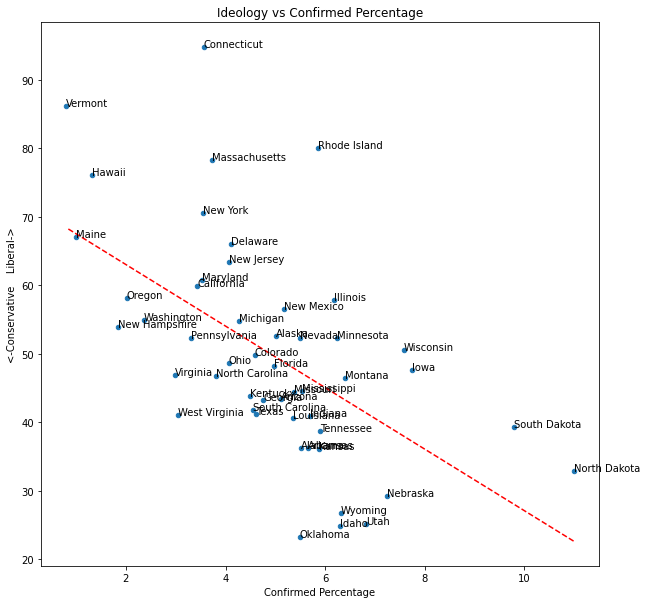

In [41]:
x = df_cp['ConfirmedPercentage']
y = df_cp['CitizenIdeology']
ax = df_cp.plot(x='ConfirmedPercentage',y='CitizenIdeology',kind='scatter',figsize=(10,10))
# Add labels to each point
df_cp[['ConfirmedPercentage','CitizenIdeology','Province/State']].apply(lambda x: ax.text(*x),axis=1)

# Add a trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.xlabel('Confirmed Percentage')
plt.ylabel('<-Conservative    Liberal->')
plt.title('Ideology vs Confirmed Percentage')

# Display r squared value
import scipy
from scipy import stats
slope, intercept, r, p, std_err = scipy.stats.linregress(x, y)
print("R Squared: "+str(r**2))

While this correlation isn't perfect, it was much higher than I was expecting. An r squared value of 0.32 using real world data that is affected by many different factor is reasonably significant for our analysis. There certainly are some outliers, but overall this data follows a noticeable trend between political ideology and percent of confirmed cases. I believe this will be useful for our algorithm.

Next, let's take a look at population density to see if we can find any correlation between that and confirmed percentage of cases.

In [42]:
# Data from: https://www.census.gov/data/tables/2010/dec/density-data-text.html
df_density = pd.read_csv('Data/pop_density.csv')
# df_density = df_density[['STATE_OR_REGION','2010_POPULATION','2010_DENSITY']]
df_density['2010_DENSITY'] = df_density['2010_DENSITY'].str.replace(',','')
df_density['2010_DENSITY'] = pd.to_numeric(df_density['2010_DENSITY'],errors='coerce')
df_density.head()

STATE_OR_REGION  1910_POPULATION  1920_POPULATION  1930_POPULATION  \
0   United States         92228531        106021568        123202660   
1         Alabama          2138093          2348174          2646248   
2          Alaska            64356            55036            59278   
3         Arizona           204354           334162           435573   
4        Arkansas          1574449          1752204          1854482   

   1940_POPULATION  1950_POPULATION  1960_POPULATION  1970_POPULATION  \
0        132165129        151325798        179323175        203211926   
1          2832961          3061743          3266740          3444165   
2            72524           128643           226167           300382   
3           499261           749587          1302161          1770900   
4          1949387          1909511          1786272          1923295   

   1980_POPULATION  1990_POPULATION  ...  1920_RANK  1930_RANK 1940_RANK  \
0        226545805        248709873  ...        NaN        NaN       NaN   
1          3893888          4040587  ...       25.0       24.0      23.0   
2           401851           550043  ...       52.0       52.0      52.0   
3          2718215          3665228  ...       49.0       47.0      47.0   
4          2286435          2350725  ...       31.0       32.0      32.0   

  1950_RANK 1960_RANK 1970_RANK 1980_RANK 1990_RANK 2000_RANK 2010_RANK  
0       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
1      24.0      28.0      28.0      28.0      27.0      28.0      29.0  
2      52.0      52.0      52.0      52.0      52.0      52.0      52.0  
3      47.0      43.0      43.0      42.0      39.0      38.0      35.0  
4      34.0      36.0      37.0      37.0      37.0      36.0      36.0  

[5 rows x 34 columns]

R Squared: 0.05136597912659773


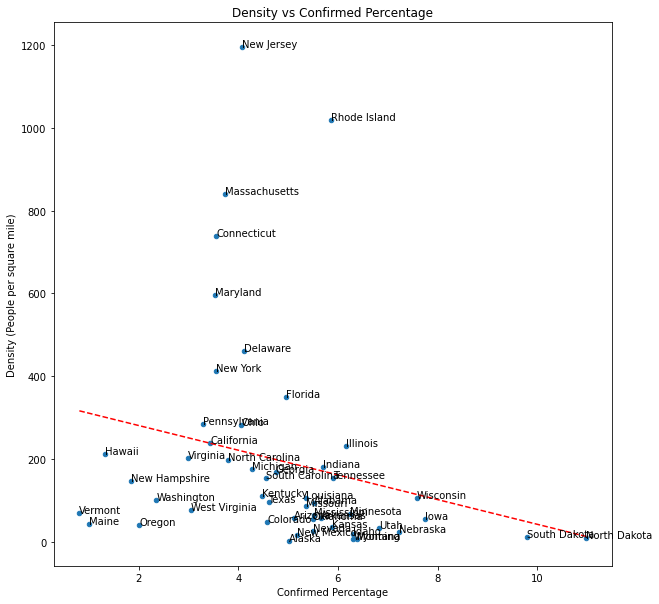

In [43]:
# df confirmed partisan density
df_cpd = df_cp.copy()
df_density = df_density.rename(columns={'STATE_OR_REGION': 'Province/State'})
df_density = df_density[['Province/State','2010_DENSITY']]
df_cpd = df_cpd.merge(df_density, on='Province/State', how='inner')


x = df_cpd['ConfirmedPercentage']
y = df_cpd['2010_DENSITY']
ax = df_cpd.plot(x='ConfirmedPercentage',y='2010_DENSITY',kind='scatter',figsize=(10,10))
# Add labels to each point
df_cpd[['ConfirmedPercentage','2010_DENSITY','Province/State']].apply(lambda x: ax.text(*x),axis=1)

# Add a trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.xlabel('Confirmed Percentage')
plt.ylabel('Density (People per square mile)')
plt.title('Density vs Confirmed Percentage')

# Display r squared value
import scipy
from scipy import stats
slope, intercept, r, p, std_err = scipy.stats.linregress(x, y)
print("R Squared: "+str(r**2))
# df_density.head(100)

Unfortunately, this r squared value is significantly lower than the correlation for political ideology. Our outlier data seems to be skewing our trendline as well. This is surprising because you might expext that more densely populated states to have higher rates since there are more people per unit area.

Next, we will import some data from census.gov with different data points and population numbers for each of them for each state. For this next graph, we will be looking at the average age of citizens in each state to see if we can find a correlation between average age and covid percentage rates.

In [44]:
# Data from: https://www.census.gov/data/datasets/time-series/demo/popest/2010s-state-detail.html
# df_asr: df age sex race
df_asr = pd.read_csv('Data/sc-est2019-alldata6.csv')
# Remove columns we don't need
df_asr = df_asr[['NAME','SEX','ORIGIN','RACE','AGE','POPESTIMATE2019']]

In [45]:
df_age = df_asr.copy()
df_age = df_age[df_age.SEX != 0]
df_age = df_age[df_age.ORIGIN != 0]
df_age = df_age[['NAME','AGE','POPESTIMATE2019']]
df_age = df_age.groupby(['NAME', 'AGE'], as_index=False).sum()
df_age['weighted'] = df_age['AGE'] * df_age['POPESTIMATE2019']
df_age = df_age.groupby(['NAME'], as_index=False).sum()
df_age['AverageAge'] = df_age['weighted'] / df_age['POPESTIMATE2019']
df_age = df_age[['NAME','AverageAge']]
df_age.head(10)

NAME  AverageAge
0               Alabama   39.482018
1                Alaska   36.330879
2               Arizona   39.170100
3              Arkansas   39.016298
4            California   38.033199
5              Colorado   38.106171
6           Connecticut   40.588005
7              Delaware   40.828502
8  District of Columbia   36.648714
9               Florida   41.874931

In [46]:
df_cpa = df_cpd.copy()

df_age = df_age.rename(columns={'NAME': 'Province/State'})
df_cpa = df_cpa.merge(df_age, on='Province/State', how='inner')
df_cpa.head()

Province/State ObservationDate  ConfirmedPercentage  state    year  \
0   North Dakota      2020-12-06            10.987397   34.0  2015.0   
1   South Dakota      2020-12-06             9.796307   41.0  2015.0   
2           Iowa      2020-12-06             7.742031   15.0  2015.0   
3      Wisconsin      2020-12-06             7.581012   49.0  2015.0   
4       Nebraska      2020-12-06             7.235729   27.0  2015.0   

   CitizenIdeology  GovernmentIdeology  2010_DENSITY  AverageAge  
0        32.864830           31.388329           9.7   37.518283  
1        39.302322           29.607647          10.7   38.462802  
2        47.608620           33.479546          54.5   39.130726  
3        50.566242           22.858555         105.0   39.849338  
4        29.198908           27.135815          23.8   37.922156

R Squared: 0.256351432924362


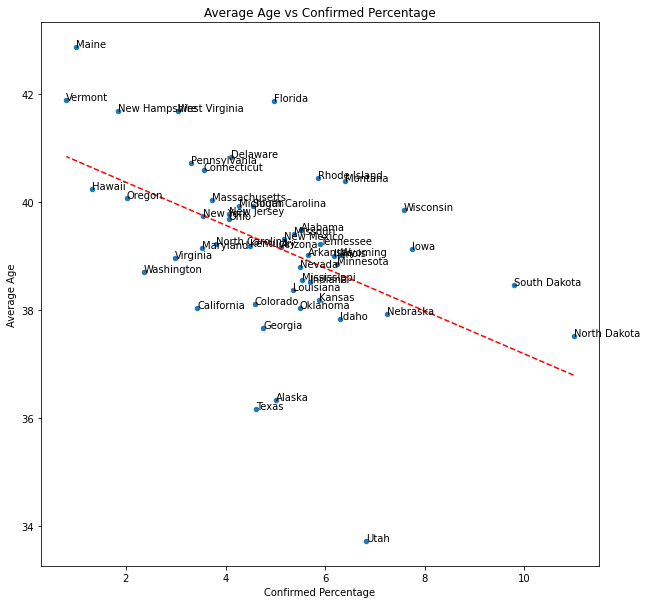

In [47]:
x = df_cpa['ConfirmedPercentage']
y = df_cpa['AverageAge']
ax = df_cpa.plot(x='ConfirmedPercentage',y='AverageAge',kind='scatter',figsize=(10,10))
# Add labels to each point
df_cpa[['ConfirmedPercentage','AverageAge','Province/State']].apply(lambda x: ax.text(*x),axis=1)

# Add a trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.xlabel('Confirmed Percentage')
plt.ylabel('Average Age')
plt.title('Average Age vs Confirmed Percentage')

# Display r squared value
import scipy
from scipy import stats
slope, intercept, r, p, std_err = scipy.stats.linregress(x, y)
print("R Squared: "+str(r**2))
# df_cpa.head(100)

With an r squared value of 0.26, we are getting a correlation closer to what we had with the political ideology. There seems to be a correlation between younger average age and higher percentages of covid cases. This would seem to make sense, since younger people are less severely affected by covid and are more likely to expose themselves to more people. While we can't necessarily make any conclusions about why this correlation exists, it would seem that there is somewhat of a correlation between average age and confirmed case percentages.

While I don't expect to see any correlation with this next set of data, let's run the analysis since we alread have the data imported into our table. This next graph will be comparing the "average" sex (ratio of male to female with male being 1 and female being 2) of each state with its covid percentage rates.

In [48]:
df_sex = df_asr.copy()
df_sex = df_sex[df_sex.SEX > 0]
df_sex = df_sex[df_sex.ORIGIN != 0]
# df_sex = df_sex[['NAME','SEX','AGE','POPESTIMATE2019']]
df_sex = df_sex.groupby(['NAME', 'SEX'], as_index=False).sum()
df_sex['weighted'] = df_sex['SEX'] * df_sex['POPESTIMATE2019']
df_sex = df_sex.groupby(['NAME'], as_index=False).sum()
df_sex['AverageSex'] = df_sex['weighted'] / df_sex['POPESTIMATE2019']
df_sex = df_sex[['NAME','AverageSex']]
df_sex.head()

NAME  AverageSex
0     Alabama    1.516739
1      Alaska    1.478613
2     Arizona    1.503031
3    Arkansas    1.509042
4  California    1.502816

In [49]:
df_cpas = df_cpa.copy()

df_sex = df_sex.rename(columns={'NAME': 'Province/State'})
df_cpas = df_cpas.merge(df_sex, on='Province/State', how='inner')
df_cpas.head()

Province/State ObservationDate  ConfirmedPercentage  state    year  \
0   North Dakota      2020-12-06            10.987397   34.0  2015.0   
1   South Dakota      2020-12-06             9.796307   41.0  2015.0   
2           Iowa      2020-12-06             7.742031   15.0  2015.0   
3      Wisconsin      2020-12-06             7.581012   49.0  2015.0   
4       Nebraska      2020-12-06             7.235729   27.0  2015.0   

   CitizenIdeology  GovernmentIdeology  2010_DENSITY  AverageAge  AverageSex  
0        32.864830           31.388329           9.7   37.518283    1.488189  
1        39.302322           29.607647          10.7   38.462802    1.494995  
2        47.608620           33.479546          54.5   39.130726    1.502047  
3        50.566242           22.858555         105.0   39.849338    1.502406  
4        29.198908           27.135815          23.8   37.922156    1.500390

R Squared: 0.13591456000979601


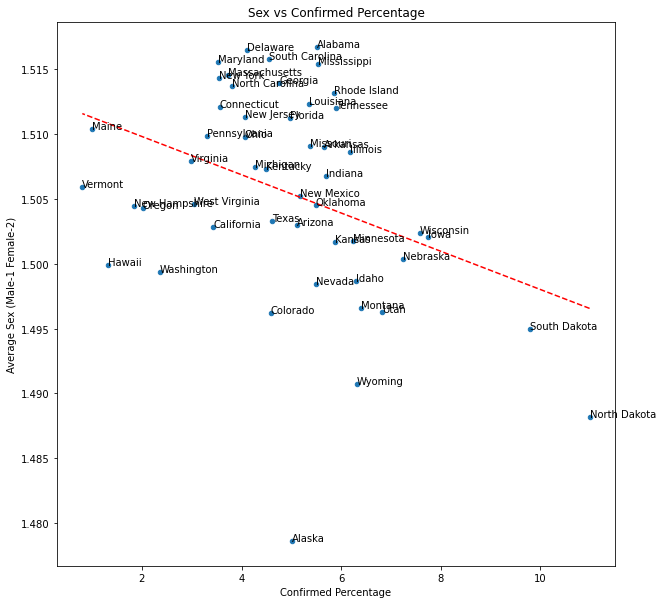

In [50]:
x = df_cpas['ConfirmedPercentage']
y = df_cpas['AverageSex']
ax = df_cpas.plot(x='ConfirmedPercentage',y='AverageSex',kind='scatter',figsize=(10,10))
# Add labels to each point
df_cpas[['ConfirmedPercentage','AverageSex','Province/State']].apply(lambda x: ax.text(*x),axis=1)

# Add a trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.xlabel('Confirmed Percentage')
plt.ylabel('Average Sex (Male-1 Female-2)')
plt.title('Sex vs Confirmed Percentage')

# Display r squared value
import scipy
from scipy import stats
slope, intercept, r, p, std_err = scipy.stats.linregress(x, y)
print("R Squared: "+str(r**2))

Unsurprisingly, there doesn't seem to be a significant correlation between sex and covid rates, however our r squared value is slightly higher than that of density at 0.14. If any correlation exists, it would seem to imply that high ratios of men related to higher percentages of covid.

Now let's take a look at average temperature and covid rates per state. I expect to see some correlation here, since warmer or colder weather would affect how much people are inside or outside.

In [51]:
# Data from: https://corgis-edu.github.io/corgis/csv/weather/
df_weather = pd.read_csv('Data/weather.csv')

# Fix column labels and remove unnecessary data
df_weather['Station.State'] = df_weather['Station.State'].replace(['DE'],'Delaware')
df_weather['Station.State'] = df_weather['Station.State'].replace(['VA'],'Virginia')
df_weather = df_weather[df_weather['Station.State'] != 'Puerto Rico']

df_weather = df_weather.groupby(['Station.State'], as_index=False).mean()
df_weather = df_weather[['Station.State','Data.Temperature.Avg Temp']]

df_weather.head()

Station.State  Data.Temperature.Avg Temp
0       Alabama                  66.528302
1        Alaska                  41.157650
2       Arizona                  66.286792
3      Arkansas                  62.308176
4    California                  62.363363

In [52]:
df_cpast = df_cpas.copy()

df_weather = df_weather.rename(columns={'Station.State': 'Province/State'})
df_weather = df_weather.rename(columns={'Data.Temperature.Avg Temp': 'AverageTemp'})
df_cpast = df_cpast.merge(df_weather, on='Province/State', how='inner')
df_cpast.head()

Province/State ObservationDate  ConfirmedPercentage  state    year  \
0   North Dakota      2020-12-06            10.987397   34.0  2015.0   
1   South Dakota      2020-12-06             9.796307   41.0  2015.0   
2           Iowa      2020-12-06             7.742031   15.0  2015.0   
3      Wisconsin      2020-12-06             7.581012   49.0  2015.0   
4       Nebraska      2020-12-06             7.235729   27.0  2015.0   

   CitizenIdeology  GovernmentIdeology  2010_DENSITY  AverageAge  AverageSex  \
0        32.864830           31.388329           9.7   37.518283    1.488189   
1        39.302322           29.607647          10.7   38.462802    1.494995   
2        47.608620           33.479546          54.5   39.130726    1.502047   
3        50.566242           22.858555         105.0   39.849338    1.502406   
4        29.198908           27.135815          23.8   37.922156    1.500390   

   AverageTemp  
0    45.166038  
1    48.415094  
2    50.796226  
3    49.165094  
4    51.634434

R Squared: 0.032898004980701896


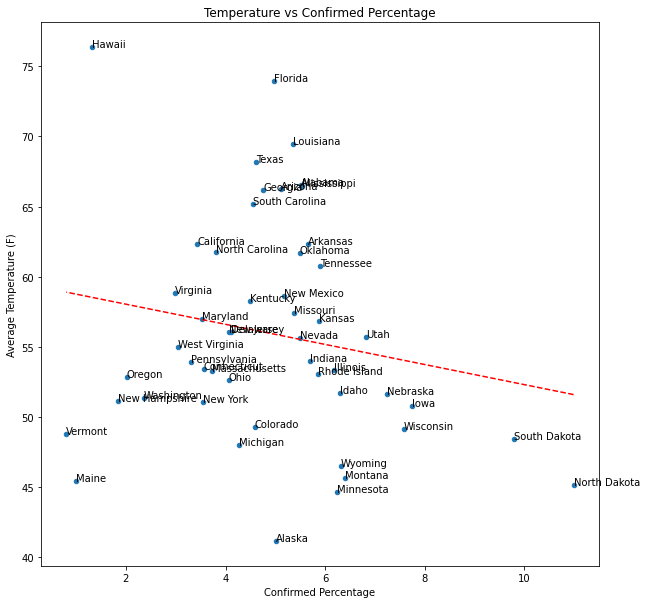

In [53]:
x = df_cpast['ConfirmedPercentage']
y = df_cpast['AverageTemp']
ax = df_cpast.plot(x='ConfirmedPercentage',y='AverageTemp',kind='scatter',figsize=(10,10))
# Add labels to each point
df_cpast[['ConfirmedPercentage','AverageTemp','Province/State']].apply(lambda x: ax.text(*x),axis=1)

# Add a trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.xlabel('Confirmed Percentage')
plt.ylabel('Average Temperature (F)')
plt.title('Temperature vs Confirmed Percentage')

# Display r squared value

slope, intercept, r, p, std_err = scipy.stats.linregress(x, y)
print("R Squared: "+str(r**2))

With an r squared of 0.03, average temperature has had the weakest correlation of all the data we looked at so far. This surprised me the most of all the data we looked at, since there seems to be no correlation at all. As I expained prior to doing this analysis, I had thought that the temperature's effect on how much time people spend indoors or outdoors would affect covid rates, but this does not seem to be the case.

Finally, let's actually run the machine learning model with our variables. We will use statsmodel to run out multiple linear regression. I will be fitting the model with some of the data that we took a look at above.
<br><br>
Let's start by running the model with just one variable to see how well it fits our data.

In [54]:
X = df_cpa['CitizenIdeology']
y = df_cpa['ConfirmedPercentage']
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     ConfirmedPercentage   R-squared:                       0.324
Model:                             OLS   Adj. R-squared:                  0.310
Method:                  Least Squares   F-statistic:                     23.06
Date:                 Mon, 21 Dec 2020   Prob (F-statistic):           1.58e-05
Time:                         15:13:23   Log-Likelihood:                -94.881
No. Observations:                   50   AIC:                             193.8
Df Residuals:                       48   BIC:                             197.6
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               8.4885      0.789     10.756      0.000       6.902      10.075
CitizenIdeology    -0.0722      0.015     -4.802      0.000      -0.102      -0.042
==============================================================================
Omnibus:                        8.465   Durbin-Watson:                   0.498
Prob(Omnibus):                  0.015   Jarque-Bera (JB):                7.607
Skew:                           0.830   Prob(JB):                       0.0223
Kurtosis:                       3.946   Cond. No.                         178.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now let's run it again, this time using multiple variables to see if we can improve our fit. Our last r squared was .32.

In [55]:
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.formula.api as smf

x = df_cpast[['CitizenIdeology','AverageAge','AverageTemp']]
y = df_cpast['ConfirmedPercentage']
model = smf.ols(formula='ConfirmedPercentage ~ CitizenIdeology + AverageAge + AverageTemp', data=df_cpast).fit()

plt.rcParams["figure.figsize"] = (12,10)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     ConfirmedPercentage   R-squared:                       0.437
Model:                             OLS   Adj. R-squared:                  0.400
Method:                  Least Squares   F-statistic:                     11.89
Date:                 Mon, 21 Dec 2020   Prob (F-statistic):           6.89e-06
Time:                         15:13:23   Log-Likelihood:                -90.338
No. Observations:                   50   AIC:                             188.7
Df Residuals:                       46   BIC:                             196.3
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          24.7420      6.368      3.885      0.000      11.923      37.561
CitizenIdeology    -0.0567      0.017     -3.367      0.002      -0.091      -0.023
AverageAge         -0.3466      0.168     -2.061      0.045      -0.685      -0.008
AverageTemp        -0.0613      0.028     -2.178      0.035      -0.118      -0.005
==============================================================================
Omnibus:                        3.623   Durbin-Watson:                   0.815
Prob(Omnibus):                  0.163   Jarque-Bera (JB):                2.861
Skew:                           0.579   Prob(JB):                        0.239
Kurtosis:                       3.174   Cond. No.                     2.50e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.5e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [56]:
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.formula.api as smf

# df_cpast = df_cpast.rename()
df_cpast = df_cpast.rename(columns={'2010_DENSITY': 'Density'})

x = df_cpast[['CitizenIdeology','AverageAge','AverageTemp','Density','AverageSex']]
y = df_cpast['ConfirmedPercentage']
model = smf.ols(formula='ConfirmedPercentage ~ CitizenIdeology + AverageAge + AverageTemp + AverageSex + Density', data=df_cpast).fit()

plt.rcParams["figure.figsize"] = (12,10)

model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     ConfirmedPercentage   R-squared:                       0.473
Model:                             OLS   Adj. R-squared:                  0.413
Method:                  Least Squares   F-statistic:                     7.885
Date:                 Mon, 21 Dec 2020   Prob (F-statistic):           2.27e-05
Time:                         15:13:23   Log-Likelihood:                -88.694
No. Observations:                   50   AIC:                             189.4
Df Residuals:                       44   BIC:                             200.9
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          61.7979     59.074      1.046      0.301     -57.258     180.854
CitizenIdeology    -0.0770      0.020     -3.757      0.001      -0.118      -0.036
AverageAge         -0.2724      0.188     -1.448      0.155      -0.651       0.107
AverageTemp        -0.0567      0.034     -1.651      0.106      -0.126       0.012
AverageSex        -26.3102     41.993     -0.627      0.534    -110.942      58.321
Density             0.0020      0.001      1.722      0.092      -0.000       0.004
==============================================================================
Omnibus:                        3.044   Durbin-Watson:                   0.817
Prob(Omnibus):                  0.218   Jarque-Bera (JB):                2.632
Skew:                           0.561   Prob(JB):                        0.268
Kurtosis:                       2.922   Cond. No.                     1.11e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.11e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0.5, 1.0, 'Actual vs Predicted')

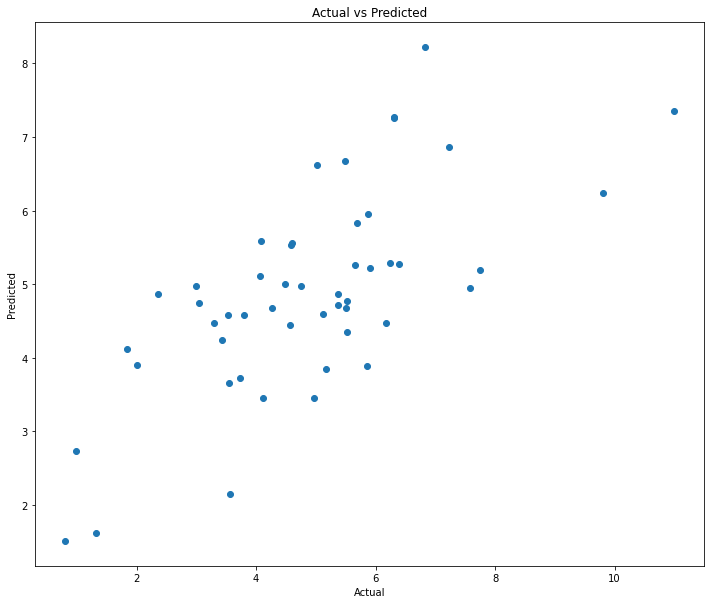

In [57]:
pred = model.predict(x)

plt.scatter(y,pred)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')

# Conclusion

The COVID-19 pandemic has had a massive impact on the world and has caused some significant changes in the way we all live our lives. As unfortunate of an event as this is, it is great to see a wealth of publicly available data on a global scale relating to the pandemic.
<br><br>
I found the two most interesting parts of this tutorial to be the choropleth map and machine learning process. Being able to see the progression of the virus using the slider on the map was super fascinating. I also found the process of finding other datasets to be used in combination with the covid one for the machine learning algorithm to be interesting as well. I was especially intrigued by the correlation we saw between political affiliation and percentage rates of COVID-19 in each state.
<br><br>
Utilizing the libraries and tools available for free within python, we can manipulate and analyze this data to learn some really cool and interesting things about how this virus has affected different countries and states/provinces within those countries. It will be really interesting to see how the results of this analysis change over time as more data becomes available, especially as more and more vaccines are becoming available. Additionally, while this tutorial covers a lot of the analysis you can do with this dataset, there are certainly many ways in which you could expand and further analyze the data to learn even more about COVID-19's affects on the world around us. Utilizing this data in combination with other publicly available datasets can result in an even more thorough and detailed understanding of this pandemic and its effects.